# CYCLING IN SYDNEY

## 0. startup code

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime
import matplotlib.dates as mdates
try:
    import geopandas as gp
    import shapely
except Exception as e:
    print(e, "geopandas stuff will fail later on")

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
saved_style_state = matplotlib.rcParams.copy()

## 1. importing data

In [5]:
if os.path.isfile("Cycleway Counts_01Jan18_11Sept20.xlsx"):
    filepath = "Cycleway Counts_01Jan18_11Sept20.xlsx"
    print("loading from file")
else:
    filepath = "https://opendata.transport.nsw.gov.au/system/files/resources/Cycleway%20Counts_01Jan18_11Sept20.xlsx"
    print("loading from the internet")

cycleway_usage = pd.read_excel(
    filepath, sheet_name="daily counts", dtype={"station": int, "counter": int}
)
print("done")


loading from file
done


### 1.a ben's assistance

In [6]:
dir_lookup = ["North", "East", "South", "West", "All Directions"]
def get_mode(index):
    if index<5:
        return "Cycling"
    else:
        return "Pedestrian"

locations_sparse = [x for x in cycleway_usage.columns if "Unnamed" not in x ]

In [7]:
def get_loc(i, response_type="all"):
    try:
        loc = locations_sparse[math.ceil(i/15)]
        if response_type == "all":
            return loc
        elif response_type == "code":
            return loc.split("-")[0].strip()
        elif response_type == "name":
            return loc.split("-")[1].strip()
        # You can extend this to pull out the notes, like (Cycleway and Pedestrian counter), but they're pretty inconsistent
        else:
            print(f"`{response_type}` is not implemented yet")
    except:
        print("er")


In [8]:
new_rows = []
for i, row in cycleway_usage.iterrows():
    if i < 3:
        continue  # This feels nasty

    date = row[0]
    for loc_index in range(1, len(row) - 15, 15):
        section = row[
            loc_index : loc_index + 10
        ]  # 10 because we don't care about the Sum (All Transport Modes) section
        for col_index, col in enumerate(section):
            dir = dir_lookup[col_index % 5]
            if type(col) is int and col != 0 and dir != "All Directions":
                r = {
                    "date": date,
                    "location_name": get_loc(loc_index, "name"),
                    "station": get_loc(loc_index, "code"),
                    "mode_transport": get_mode(col_index),
                    "direction": dir,
                    "counter": int(col),
                }
                new_rows.append(r)

### 1.b converting datetime

In [9]:
time_df = pd.DataFrame(new_rows)
time_df.head()

,date,location_name,station,mode_transport,direction,counter
0,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
1,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,South,5
2,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Pedestrian,North,7
3,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Pedestrian,South,7
4,02/01/2018,"Ridge St Bridge, North Sydney (Cycleway and Pe...",100009,Pedestrian,East,88


In [10]:
time_df.iloc[0].date

'02/01/2018'

In [11]:
time_df['date_dt'] = pd.to_datetime(time_df['date'], infer_datetime_format=True, dayfirst=True)
time_df.sort_values(by='date_dt', inplace=True) 
time_df.set_index("date_dt", inplace=True)
time_df.head()

,date,location_name,station,mode_transport,direction,counter
date_dt,,,,,,
2018-01-02,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
2018-01-02,02/01/2018,"Liverpool to Parramatta Rail Trail, Railway Te...",90905,Cycling,South,35
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,East,270
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,West,255
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Pedestrian,East,75


In [12]:
new_counterdf = time_df.drop(columns=['date'])
new_counterdf.head()

,location_name,station,mode_transport,direction,counter
date_dt,,,,,
2018-01-02,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
2018-01-02,"Liverpool to Parramatta Rail Trail, Railway Te...",90905,Cycling,South,35
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,East,270
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,West,255
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Pedestrian,East,75


In [13]:
new_counterdf["station"] = new_counterdf.station.apply(lambda x: int(x))
new_counterdf.head()

,location_name,station,mode_transport,direction,counter
date_dt,,,,,
2018-01-02,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
2018-01-02,"Liverpool to Parramatta Rail Trail, Railway Te...",90905,Cycling,South,35
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,East,270
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,West,255
2018-01-02,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Pedestrian,East,75


In [14]:
print(new_counterdf.shape) 

(43329, 5)


### Questions
* Who is travelling into the city, out of the city?
* Weekdays vs weekend? See comparison, poor connections? Limitations of only pathways/single counter?

## 2. data visualisation over time
* per day/ per month bar chart
* section off weekends?
* weekdays?

### 2.a making useful graphs

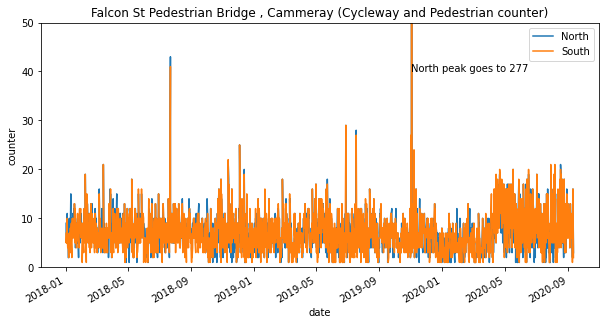

In [15]:
cammeray_counterdf = new_counterdf[new_counterdf.station == 100008]
north_data = cammeray_counterdf[cammeray_counterdf.direction == "North"]["counter"]
south_data = cammeray_counterdf[cammeray_counterdf.direction == "South"]["counter"]
north_data.plot(label="North")
south_data.plot(label="South")
# plt.ylim([0, 300])
plt.ylim([0, 50])
plt.title(cammeray_counterdf.iloc[0].location_name)
plt.xlabel("date")
plt.ylabel("counter")
max_n_val = north_data.max()
max_n_idx = north_data.idxmax()
plt.annotate(f"North peak goes to {max_n_val}", xy=(mdates.date2num(max_n_idx), 40))
plt.legend()


Text(0.5, 1.0, 'Falcon St Pedestrian Bridge , Cammeray (Cycleway and Pedestrian counter)')

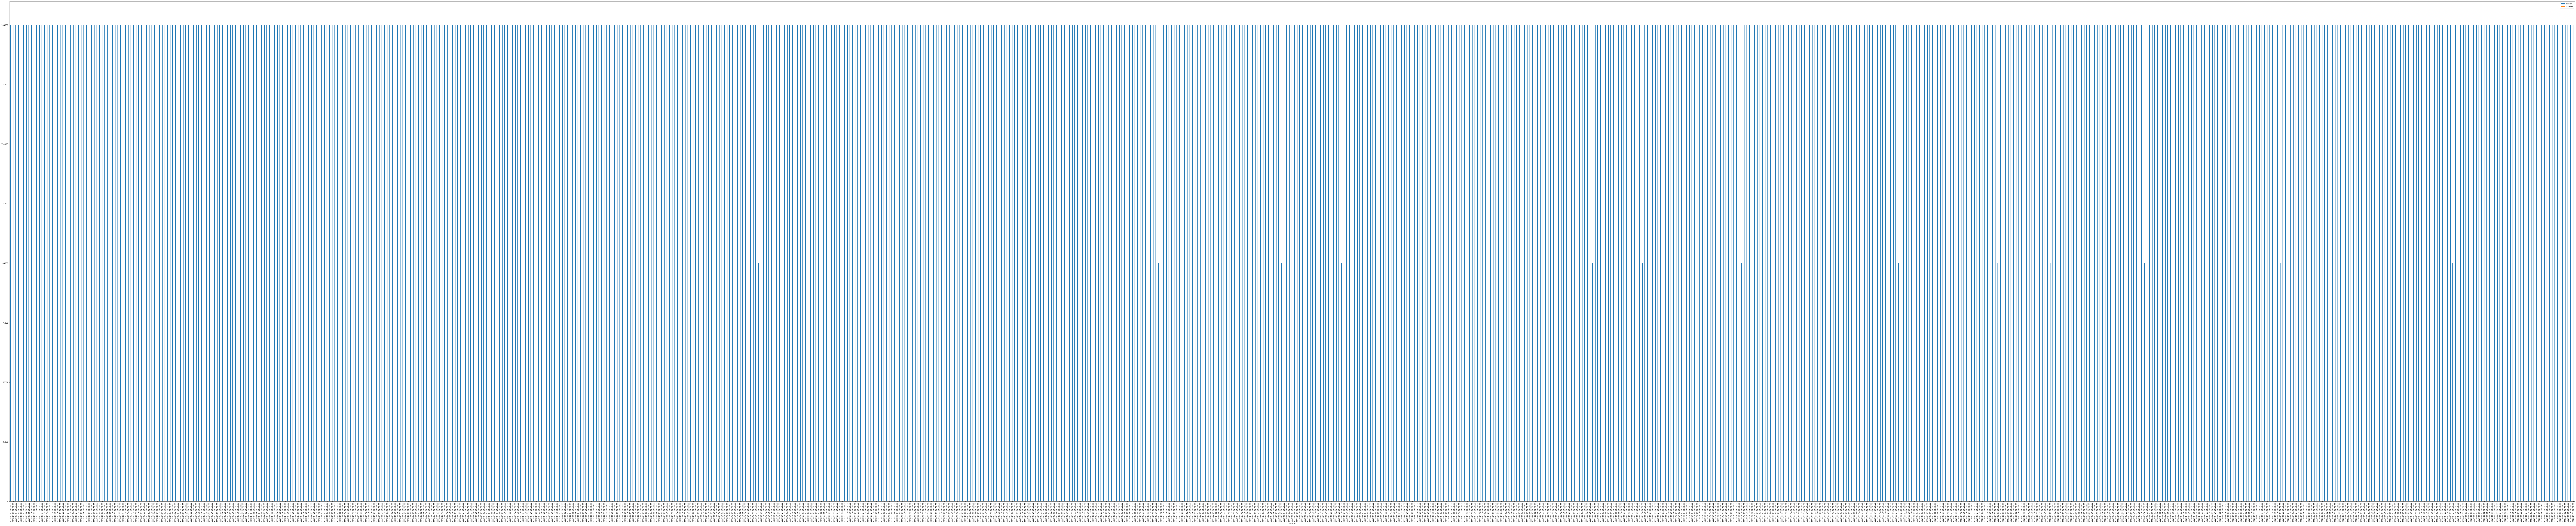

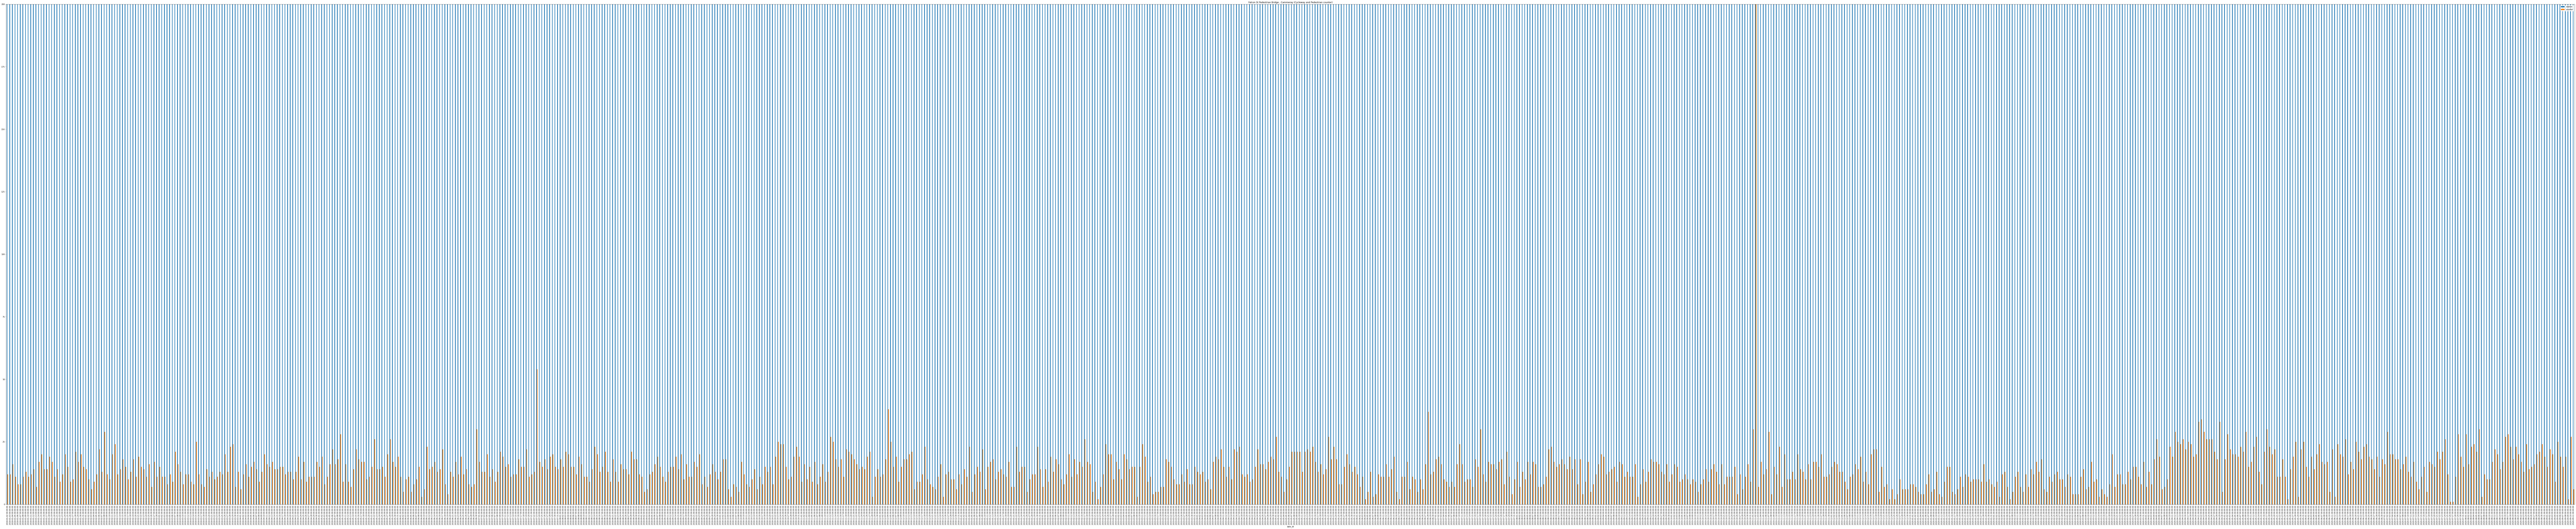

In [16]:
#cammeray_counterdf[cammeray_counterdf.direction=="South"]["counter"].plot.hist( )
#bar chart way more useful than line for this part
#cammeray_counterdf[cammeray_counterdf.direction=="North"]["counter"].plot.hist(column=["date_dt"], by="counter", figsize=(10, 8))
#copypaste
#cammeray_counterdf[cammeray_counterdf.direction=="North"].plot.hist(column="date_dt", by="counter")
#this one should work???
#cammeray_counterdf.groupby(['direction']).sum().plot(kind='histogram', y='counter')
#cammeray_counterdf.plot.bar()

#cammeray_counterdf.groupby(by=[cammeray_counterdf.index.month, cammeray_counterdf.index.year])
#trying to make the bar chart ylabels a bit more readable (per month?)
#cammeray_counterdf.groupby(pd.Grouper(freq='M'))
#cammeray_counterdf2=cammeray_counterdf.groupby(cammeray_counterdf.date_dt.month)['counter'].sum()
#cammeray_counterdf.groupby(pd.Grouper(key='date_dt', axis=0, freq='M')).sum()

#cammeray_counterdf[cammeray_counterdf.direction=="North"].groupby(['date_dt']).sum().plot.bar(figsize=(250,50))

#cammeray_counterdf[cammeray_counterdf.direction=="South"].plot.bar( )
cammeray_counterdf[cammeray_counterdf.direction=="North"].groupby(['date_dt']).sum().plot.bar(figsize=(250,50))
cammeray_counterdf[cammeray_counterdf.direction=="South"].groupby(['date_dt']).sum().plot.bar(figsize=(250,50))
#trying to show data after 2020
#cammeray_counterdf[cammeray_counterdf.direction=="North"][cammeray_counterdf["date_dt"] < "01/01/2020"].groupby(['date_dt']).sum().plot.bar(figsize=(250,50))
plt.ylim([0, 200])
plt.title(cammeray_counterdf.iloc[0].location_name)

<AxesSubplot:ylabel='direction'>

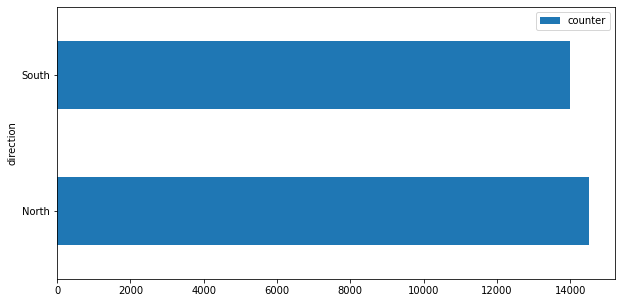

In [17]:
cammeray_counterdf.groupby(['direction']).sum().plot(kind='barh', y='counter')
#not what I want but getting close?

(0.0, 750.0)

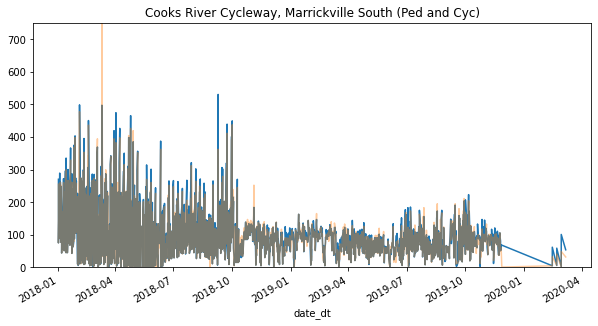

In [19]:
marrickville_counterdf = new_counterdf[new_counterdf.station==90909]
marrickville_counterdf[marrickville_counterdf.direction=="East"]["counter"].plot( )
marrickville_counterdf[marrickville_counterdf.direction=="West"]["counter"].plot(alpha=0.4)
plt.title(marrickville_counterdf.iloc[0].location_name)
plt.ylim([0, 750])

<AxesSubplot:xlabel='date_dt'>

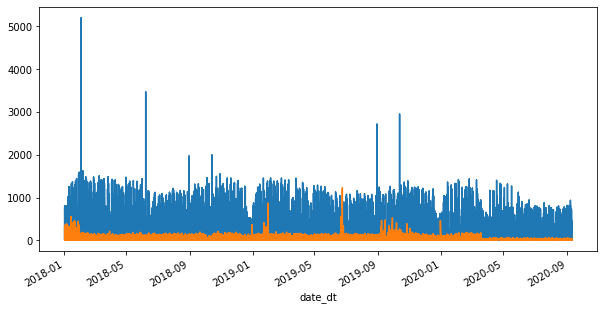

In [19]:
new_counterdf[new_counterdf.mode_transport=="Cycling"]["counter"].plot( )
new_counterdf[new_counterdf.mode_transport=="Pedestrian"]["counter"].plot( )
#plot within one dataset???

<AxesSubplot:ylabel='counter'>

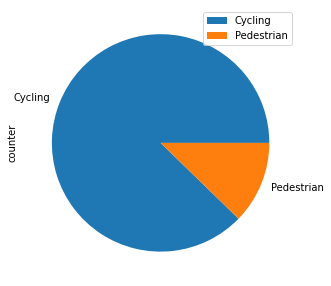

In [20]:
#new_counterdf[new_counterdf.mode_transport].plot.pie(y='counter', labels='mode_transport')
new_counterdf.groupby(['mode_transport']).sum().plot(kind='pie', y='counter')

Text(0.5, 1.0, 'Cooks River Cycleway, Marrickville South (Ped and Cyc)')

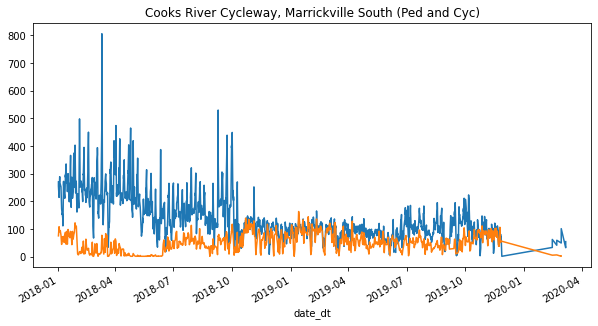

In [21]:
marrickville_counterdf[marrickville_counterdf.mode_transport=="Cycling"]["counter"].plot( )
marrickville_counterdf[marrickville_counterdf.mode_transport=="Pedestrian"]["counter"].plot( )
plt.title(marrickville_counterdf.iloc[0].location_name)

## 3. data visualisation linked to location
* plot points on a map
* set size relation to counter (int)
* set colour/arrow relation to counter/direction
* where is there a lot of cycling? 

### 3.1 merging counter location

In [22]:
if os.path.isfile("cyclecounters-Oct-2019.csv"):
    counterfilepath = "cyclecounters-Oct-2019.csv"
    print("loading from file")
else:
    counterfilepath = "https://opendata.transport.nsw.gov.au/node/6771/download"
    print("loading from the internet")

cycleway_counterlocation = pd.read_csv(counterfilepath)
print("done")

loading from file
done


In [23]:
cycleway_counterlocation.columns

Index(['objectid', 'station', 'region', 'geolocation', 'location', 'shortname',
       'notes', 'y_2018_oct', 'y_2018_nov', 'y_2018_dec', 'y_2019_jan',
       'y_2019_feb', 'y_2019_mar', 'y_2019_apr', 'y_2019_may', 'y_2019_jun',
       'y_2019_jul', 'y_2019_aug', 'y_2019_sep', 'y_month_max', 'y_2007',
       'y_2008', 'y_2009', 'y_2010', 'y_2011', 'y_2012', 'y_2013', 'y_2014',
       'y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2019', 'y_max_year',
       'active'],
      dtype='object')

In [38]:
cycleway_counterlocation.sort_values(by='station', inplace=True)
cols_to_drop = [
       'objectid', 'location', 'region', 'y_2018_oct', 'y_2018_nov', 'y_2018_dec', 
       'y_2019_jan','y_2019_feb', 'y_2019_mar', 'y_2019_apr', 'y_2019_may', 
       'y_2019_jun', 'y_2019_jul', 'y_2019_aug', 'y_2019_sep', 'y_month_max', 
       'y_2007', 'y_2008', 'y_2009', 'y_2010', 'y_2011', 'y_2012', 'y_2013', 
       'y_2014', 'y_2015', 'y_2016', 'y_2017', 'y_2018', 'y_2019', 'y_max_year'
]
counterstation_df = cycleway_counterlocation.drop(
       columns=cols_to_drop,
       errors="ignore"
)
counterstation_df.head()

,station,geolocation,shortname,notes,active
8,30011,-33.860980 151.164268,Iron Cove Bridge,Interruptions due to construction work 2010/11...,Y
0,90902,-33.858959 151.206218,Sydney Harbour Bridge,None,Y
1,90903,-33.867926 151.181554,Anzac Bridge,Counter inoperable from Feb 2015 to Oct 2015.,Y
21,90904,-33.89126 150.94075,Liverpool to Paramatta Rail Trail Cabramatta,Closed in 2012 due to work on Southern Sydney ...,Y
22,90905,-33.851949 150.986339,Liverpool to Parramatta Rail Trail Guildford,Counter inoperable Mar 2014 to June 2015.,Y


In [33]:
# pre-work
print("new_counterdf", new_counterdf.columns)
print("counterstation_df", counterstation_df.columns)
print("Common columns: ", set(new_counterdf.columns).intersection(set(counterstation_df.columns)))


new_counterdf Index(['location_name', 'station', 'mode_transport', 'direction', 'counter'], dtype='object')
counterstation_df Index(['station', 'region', 'geolocation', 'shortname', 'notes', 'active'], dtype='object')
Common columns:  {'station'}


In [41]:
#joining geolocation to data
merged_df = pd.merge(new_counterdf, counterstation_df, on='station')
print(merged_df.shape)
merged_df.sample()

(40217, 9)


,location_name,station,mode_transport,direction,counter,geolocation,shortname,notes,active
4698,"Liverpool to Parramatta Rail Trail, Railway Te...",90905,Cycling,South,33,-33.851949 150.986339,Liverpool to Parramatta Rail Trail Guildford,Counter inoperable Mar 2014 to June 2015.,Y


### 3.2 geopandas

In [35]:
gdf = gp.GeoDataFrame(counterstation_df)


<AxesSubplot:>

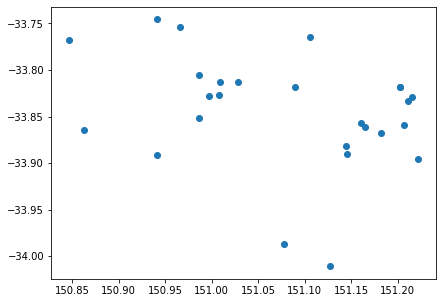

In [36]:
def make_a_point(loc_string):
    lat, lon = [float(x) for x in loc_string.split(" ")]
    return shapely.geometry.Point(lon, lat)

gdf.geometry = gdf.geolocation.apply(make_a_point)
gdf.plot()

In [ ]:
if os.path.isfile("Cycle_network.geojson"):
    cyclemap = "Cycle_network.geojson"
    print("loading from file")
else:
    cyclemap = "https://opendata.transport.nsw.gov.au/node/6771/download"
    print("loading from the internet")

cycleway_map = gp.read_file(cyclemap)
print("done")

loading from file
done


In [ ]:
cycleway_map.head()

,OBJECTID,RouteType,Source,Shape__Length,geometry
0,1,Separated off-road cycleway,2017 Sydney Cycling Guide and Map (Hardcopy pu...,469.101736,"LINESTRING (151.19943 -33.87661, 151.19916 -33..."
1,2,Separated off-road cycleway,2017 Sydney Cycling Guide and Map (Hardcopy pu...,111.214381,"LINESTRING (151.21908 -33.86977, 151.21915 -33..."
2,3,Separated off-road cycleway,2017 Sydney Cycling Guide and Map (Hardcopy pu...,175.037503,"LINESTRING (151.21484 -33.88081, 151.21488 -33..."
3,4,Separated off-road cycleway,2017 Sydney Cycling Guide and Map (Hardcopy pu...,18.417650,"LINESTRING (151.20401 -33.86277, 151.20399 -33..."
4,5,Separated off-road cycleway,2017 Sydney Cycling Guide and Map (Hardcopy pu...,280.328830,"LINESTRING (151.20302 -33.90095, 151.20241 -33..."


In [22]:
if os.path.isfile("NOV21_NSW_LOC_POLYGON_shp\nsw_localities.shp"):
    mapfilepath = "NOV21_NSW_LOC_POLYGON_shp\nsw_localities.shp"
    print("loading from file")
else:
    mapfilepath = "https://data.gov.au/data/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/5e295412-357c-49a2-98d5-6caf099c2339/download/nov21_nsw_loc_polygon_shp.zip"
    print("loading from the internet")

print("done")

loading from the internet
done


In [ ]:
sydney_map = gp.GeoDataFrame.from_file(mapfilepath)
sydney_map.set_crs

<AxesSubplot:>

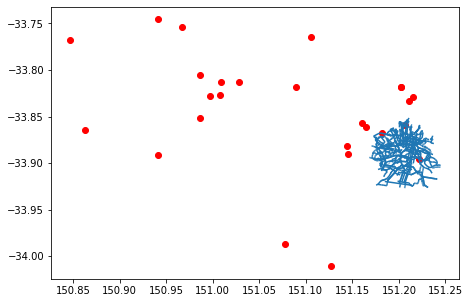

In [ ]:
base = cycleway_map.plot()
gdf.plot(ax=base, c='red')
#add map

## 4. next steps?
* import datasets from Strava, Google Maps, layer over data
* understand why cycling is used: recreation/commuting?
* understand why cycling is *NOT* used
* start playing with cycle pathways?
* feed into research: making Parramatta road a cycleway

python -m notebook HOW TO RUN PRESENTATION